In [1]:
import pandas as pd
import string 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re


from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE


from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RandomizedSearchCV


from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE


from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from datetime import datetime
import pickle

--- 
Toda variação de dados e estratégia será executada com 3 algoritmos: 
RandomForestClassifier, LGBMClassifier e XGBClassifier


A escolha se deu por serem os 3 algoritmos que melhor responderam nos testes iniciais

---

A lista final de modelos e suas características será apresentada no DataFrame abaixo. 

Foram acrescentadas as informações:
* colunas_selection: método e quantidade de colunas selecionadas
* metodo_balanceamento: método usado para o balanceamento
* data_cleaning: alguma informação relevante para datacleanin

In [2]:
lista_modelos = pd.DataFrame()
lista_modelos

""


In [3]:
#Função para executar algoritmos 

def executaAlgoritmo(pestimator, pX_train, py_train, pX_test, py_test):

    cv = cross_validate(estimator=pestimator, X=pX_train, y=py_train, scoring='roc_auc', return_train_score=True)
    
    for i in cv.keys():
        print(f'{i} : {cv[i]}')
    
    
    print('\n')
    pestimator.fit(pX_train, py_train)
    
    
    f_y_proba = pestimator.predict_proba(pX_test)
    f_y_pred = pestimator.predict(pX_test)

    print(f'ROC_AUC:\n{roc_auc_score(py_test, f_y_proba[:,1])}\n')
    print(f'Matriz de Confusão:\n{confusion_matrix(py_test, f_y_pred)}')
    
    print('\n')
    
    return pestimator, f_y_pred, f_y_proba, cv

In [4]:
def avalicaoModelo(estimator, X, y):
    y_proba = estimator.predict_proba(X)
    y_pred = estimator.predict(X)

    roc = roc_auc_score(y, y_proba[:,1])
    cv = confusion_matrix(y, y_pred)
    
    print(f'ROC_AUC:\n{roc}\n')
    print(f'Matriz de Confusão:\n{cv}')
    
    return roc, cv
    
    

# Análise Exploratória

Visualização geral dos dados. Como tem muita coluna, não foi feito nenhum gráfico de relação entre elas

## Describes

In [5]:
df = pd.read_csv('train_databricks.csv')
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9]+', '', x))

In [6]:
df.shape

(246008, 122)

In [7]:
df.head()

,SKIDCURR,TARGET,CNTCHILDREN,DAYSBIRTH,DAYSEMPLOYED,DAYSREGISTRATION,DAYSIDPUBLISH,OWNCARAGE,FLAGMOBIL,FLAGEMPPHONE,...,ELEVATORSMEDI,ENTRANCESMEDI,FLOORSMAXMEDI,FLOORSMINMEDI,LANDAREAMEDI,LIVINGAPARTMENTSMEDI,LIVINGAREAMEDI,NONLIVINGAPARTMENTSMEDI,NONLIVINGAREAMEDI,TOTALAREAMODE
0,336639,1,1,12226,496,4292,4668,11.0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,289004,0,1,11562,710,1030,3558,NaN,1,1,...,0.2,0.1724,0.3333,0.375,0.0242,0.1539,0.1987,0.0039,0.0296,0.1703
2,240024,0,0,16427,3385,2208,4032,11.0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,347406,1,2,12069,753,5961,3148,NaN,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,302895,0,2,13359,469,1404,4364,11.0,1,1,...,NaN,0.1379,0.1667,NaN,NaN,NaN,0.0696,NaN,NaN,0.0537


---
Describe separado por tipos pra facilitar a visualização

---

In [8]:
df.describe(include='object')

,NAMECONTRACTTYPE,CODEGENDER,FLAGOWNCAR,FLAGOWNREALTY,NAMETYPESUITE,NAMEINCOMETYPE,NAMEEDUCATIONTYPE,NAMEFAMILYSTATUS,NAMEHOUSINGTYPE,OCCUPATIONTYPE,WEEKDAYAPPRPROCESSSTART,ORGANIZATIONTYPE,FONDKAPREMONTMODE,HOUSETYPEMODE,WALLSMATERIALMODE,EMERGENCYSTATEMODE
count,246008,246008,246008,246008,244960,246008,246008,246008,246008,168771,246008,246008,77616,122468,120844,129247
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,222622,161867,162355,170535,198726,126919,174831,157074,218258,44126,43046,54495,58983,120287,52819,127375


In [9]:
df.describe(include='int')

,SKIDCURR,TARGET,CNTCHILDREN,DAYSBIRTH,DAYSEMPLOYED,DAYSREGISTRATION,DAYSIDPUBLISH,FLAGMOBIL,FLAGEMPPHONE,FLAGWORKPHONE,...,FLAGDOCUMENT12,FLAGDOCUMENT13,FLAGDOCUMENT14,FLAGDOCUMENT15,FLAGDOCUMENT16,FLAGDOCUMENT17,FLAGDOCUMENT18,FLAGDOCUMENT19,FLAGDOCUMENT20,FLAGDOCUMENT21
count,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,...,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000
mean,278280.072908,0.081176,0.415527,16042.794393,-63963.755699,4988.033300,2991.647642,0.999996,0.819481,0.199095,...,0.000008,0.003581,0.002951,0.001175,0.009996,0.000264,0.007975,0.000589,0.000508,0.000289
std,102790.909988,0.273106,0.719922,4365.973763,141400.318322,3520.987047,1510.020637,0.002016,0.384620,0.399321,...,0.002851,0.059736,0.054244,0.034255,0.099477,0.016253,0.088948,0.024271,0.022536,0.016986
min,100002.000000,0.000000,0.000000,7489.000000,-365243.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189165.500000,0.000000,0.000000,12418.000000,289.000000,2018.000000,1715.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278392.500000,0.000000,0.000000,15763.000000,1215.000000,4503.000000,3250.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,367272.250000,0.000000,1.000000,19691.000000,2758.000000,7481.000000,4297.250000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,456255.000000,1.000000,19.000000,25229.000000,17912.000000,23738.000000,7197.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
df.describe(include='float')

,OWNCARAGE,CNTFAMMEMBERS,OBS30CNTSOCIALCIRCLE,DEF30CNTSOCIALCIRCLE,OBS60CNTSOCIALCIRCLE,DEF60CNTSOCIALCIRCLE,DAYSLASTPHONECHANGE,AMTREQCREDITBUREAUHOUR,AMTREQCREDITBUREAUDAY,AMTREQCREDITBUREAUWEEK,...,ELEVATORSMEDI,ENTRANCESMEDI,FLOORSMAXMEDI,FLOORSMINMEDI,LANDAREAMEDI,LIVINGAPARTMENTSMEDI,LIVINGAREAMEDI,NONLIVINGAPARTMENTSMEDI,NONLIVINGAREAMEDI,TOTALAREAMODE
count,83649.000000,246007.000000,245195.000000,245195.000000,245195.000000,245195.000000,246007.000000,212836.000000,212836.000000,212836.000000,...,114800.000000,122064.000000,123525.000000,79009.000000,99921.000000,77730.000000,122391.000000,75094.000000,110148.000000,127171.000000
mean,12.034346,2.150760,1.423598,0.144045,1.406803,0.100691,962.705390,0.006291,0.006944,0.034487,...,0.078030,0.149187,0.225701,0.231482,0.066967,0.101897,0.108541,0.008503,0.028191,0.102518
std,11.861705,0.909167,2.423894,0.449464,2.402398,0.364917,826.831325,0.083236,0.109538,0.204179,...,0.134423,0.100206,0.144954,0.161801,0.081824,0.093252,0.112075,0.046307,0.069892,0.107308
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,273.000000,0.000000,0.000000,0.000000,...,0.000000,0.069000,0.166700,0.083300,0.018700,0.051300,0.045700,0.000000,0.000000,0.041200
50%,9.000000,2.000000,0.000000,0.000000,0.000000,0.000000,757.000000,0.000000,0.000000,0.000000,...,0.000000,0.137900,0.166700,0.208300,0.048600,0.076100,0.074900,0.000000,0.003050,0.068800
75%,15.000000,3.000000,2.000000,0.000000,2.000000,0.000000,1570.000000,0.000000,0.000000,0.000000,...,0.120000,0.206900,0.333300,0.375000,0.086500,0.123100,0.130300,0.003900,0.026600,0.127500
max,91.000000,20.000000,348.000000,34.000000,344.000000,24.000000,4292.000000,4.000000,9.000000,8.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## DAYS_EMPLOYED 

Atributo que chamou a atenção por ter valores negativos

### Análise

In [11]:
df[['DAYSEMPLOYED']].describe()

,DAYSEMPLOYED
count,246008.000000
mean,-63963.755699
std,141400.318322
min,-365243.000000
25%,289.000000
50%,1215.000000
75%,2758.000000
max,17912.000000


In [12]:
df[['DAYSEMPLOYED']].value_counts()

DAYSEMPLOYED
-365243         44399
 230              131
 224              130
 212              121
 199              119
                ...  
 10444              1
 10446              1
 10450              1
 10452              1
 17912              1
Length: 12074, dtype: int64

In [13]:
#visualização geral dos dados com DAYS_EMPLOYED problemático
df[df['DAYSEMPLOYED'] < 0]

,SKIDCURR,TARGET,CNTCHILDREN,DAYSBIRTH,DAYSEMPLOYED,DAYSREGISTRATION,DAYSIDPUBLISH,OWNCARAGE,FLAGMOBIL,FLAGEMPPHONE,...,ELEVATORSMEDI,ENTRANCESMEDI,FLOORSMAXMEDI,FLOORSMINMEDI,LANDAREAMEDI,LIVINGAPARTMENTSMEDI,LIVINGAREAMEDI,NONLIVINGAPARTMENTSMEDI,NONLIVINGAREAMEDI,TOTALAREAMODE
9,126503,0,0,23484,-365243,10839,885,NaN,1,0,...,0.16,0.1379,0.3333,NaN,0.0573,NaN,0.1541,NaN,0.0015,0.1194
10,288798,0,0,20093,-365243,4550,3555,NaN,1,0,...,NaN,0.2414,0.1667,NaN,NaN,NaN,0.1176,NaN,0.0110,0.0909
15,328640,0,0,23544,-365243,3906,6004,22.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,290059,0,0,22694,-365243,6657,4411,NaN,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,195521,0,0,21800,-365243,4357,4438,NaN,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245988,157665,0,0,18960,-365243,3352,2513,13.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245991,184793,0,0,22880,-365243,4598,4699,20.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245992,109187,0,0,20810,-365243,4269,4297,NaN,1,0,...,0.00,0.1379,0.1250,0.0417,NaN,0.0547,0.0521,0.0,0.0000,0.0433
246001,345140,0,0,20276,-365243,5688,3139,NaN,1,0,...,NaN,0.1034,0.1667,0.2083,NaN,0.0419,0.0428,NaN,NaN,0.0584


In [14]:
# análise das informação de FLAG_EMP_PHONE
df['FLAGEMPPHONE'][df['DAYSEMPLOYED'] < 0].value_counts()

#nenhum informou telefone do trabalho

0    44399
Name: FLAGEMPPHONE, dtype: int64

In [15]:
# análise das informação de OCCUPATION_TYPE
df['OCCUPATIONTYPE'][df['DAYSEMPLOYED'] < 0].value_counts(dropna=False)

#Sem informação 

NaN               44397
Cleaning staff        2
Name: OCCUPATIONTYPE, dtype: int64

### Conclusão

Atibuir valor zero para valores negativos. A interpretação é de dado não informado

In [16]:
df.loc[df['DAYSEMPLOYED'] < 0, 'DAYSEMPLOYED'] = 0
df['DAYSEMPLOYED'].describe()

count    246008.000000
mean       1954.523207
std        2306.666246
min           0.000000
25%         289.000000
50%        1215.000000
75%        2758.000000
max       17912.000000
Name: DAYSEMPLOYED, dtype: float64

## CODE_GENDER

### Análise

In [17]:
df['CODEGENDER'].value_counts(dropna=False)

F      161867
M       84138
XNA         3
Name: CODEGENDER, dtype: int64

In [18]:
df[['TARGET','CODEGENDER']].value_counts(dropna=False)


TARGET  CODEGENDER
0       F             150487
        M              75548
1       F              11380
        M               8590
0       XNA                3
dtype: int64

### Conclusão

Por se tratar de uma informação que pode gerar algum tipo de viés no algoritmo, será desconsiderado

In [19]:
df.drop('CODEGENDER', inplace=True, axis=1)

## Avaliação de nulos

### Análise

In [20]:
nulos = {}

for i in df.columns:
    n = df[i].isna().sum()
    if n>2000: #pra filtrar quem tem mais que 1% de nulos
        nulos[i] = n
nulos

{'OWNCARAGE': 162359,
 'AMTREQCREDITBUREAUHOUR': 33172,
 'AMTREQCREDITBUREAUDAY': 33172,
 'AMTREQCREDITBUREAUWEEK': 33172,
 'AMTREQCREDITBUREAUMON': 33172,
 'AMTREQCREDITBUREAUQRT': 33172,
 'AMTREQCREDITBUREAUYEAR': 33172,
 'OCCUPATIONTYPE': 77237,
 'FONDKAPREMONTMODE': 168392,
 'HOUSETYPEMODE': 123540,
 'WALLSMATERIALMODE': 125164,
 'EMERGENCYSTATEMODE': 116761,
 'EXTSOURCE1': 138803,
 'EXTSOURCE3': 48728,
 'APARTMENTSAVG': 124955,
 'BASEMENTAREAAVG': 144090,
 'YEARSBEGINEXPLUATATIONAVG': 120096,
 'YEARSBUILDAVG': 163680,
 'COMMONAREAAVG': 171978,
 'ELEVATORSAVG': 131208,
 'ENTRANCESAVG': 123944,
 'FLOORSMAXAVG': 122483,
 'FLOORSMINAVG': 166999,
 'LANDAREAAVG': 146087,
 'LIVINGAPARTMENTSAVG': 168278,
 'LIVINGAREAAVG': 123617,
 'NONLIVINGAPARTMENTSAVG': 170914,
 'NONLIVINGAREAAVG': 135860,
 'APARTMENTSMODE': 124955,
 'BASEMENTAREAMODE': 144090,
 'YEARSBEGINEXPLUATATIONMODE': 120096,
 'YEARSBUILDMODE': 163680,
 'COMMONAREAMODE': 171978,
 'ELEVATORSMODE': 131208,
 'ENTRANCESMODE': 123944

### Conclusão

Avaliar cada caso

## Flags

As colunas FLAGS foram analisadas individualmente por serem booleanas

### Análise 

In [21]:
flags = {}

for i in df.describe(include='int').columns:
    if i.find('FLAG') >= 0:       
    
        n = df[i].value_counts(dropna=False)[0]        
        flags[i] = n
flags

{'FLAGMOBIL': 1,
 'FLAGEMPPHONE': 44409,
 'FLAGWORKPHONE': 197029,
 'FLAGCONTMOBILE': 458,
 'FLAGPHONE': 176874,
 'FLAGEMAIL': 232054,
 'FLAGDOCUMENT2': 245998,
 'FLAGDOCUMENT3': 71148,
 'FLAGDOCUMENT4': 245987,
 'FLAGDOCUMENT5': 242293,
 'FLAGDOCUMENT6': 224376,
 'FLAGDOCUMENT7': 245961,
 'FLAGDOCUMENT8': 226056,
 'FLAGDOCUMENT9': 245068,
 'FLAGDOCUMENT10': 246005,
 'FLAGDOCUMENT11': 245047,
 'FLAGDOCUMENT12': 246006,
 'FLAGDOCUMENT13': 245127,
 'FLAGDOCUMENT14': 245282,
 'FLAGDOCUMENT15': 245719,
 'FLAGDOCUMENT16': 243549,
 'FLAGDOCUMENT17': 245943,
 'FLAGDOCUMENT18': 244046,
 'FLAGDOCUMENT19': 245863,
 'FLAGDOCUMENT20': 245883,
 'FLAGDOCUMENT21': 245937}

In [22]:
df['FLAGCONTMOBILE'].value_counts()

1    245550
0       458
Name: FLAGCONTMOBILE, dtype: int64

In [23]:
df['FLAGMOBIL'].value_counts()

1    246007
0         1
Name: FLAGMOBIL, dtype: int64

In [24]:
cols_flags = list(flags.keys())
cols_flags_t = cols_flags.copy()
cols_flags_t.append('TARGET')


In [25]:
#cols_flags = ['FLAG_EMAIL','FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21']
df_flags = df[cols_flags_t]

<AxesSubplot:>

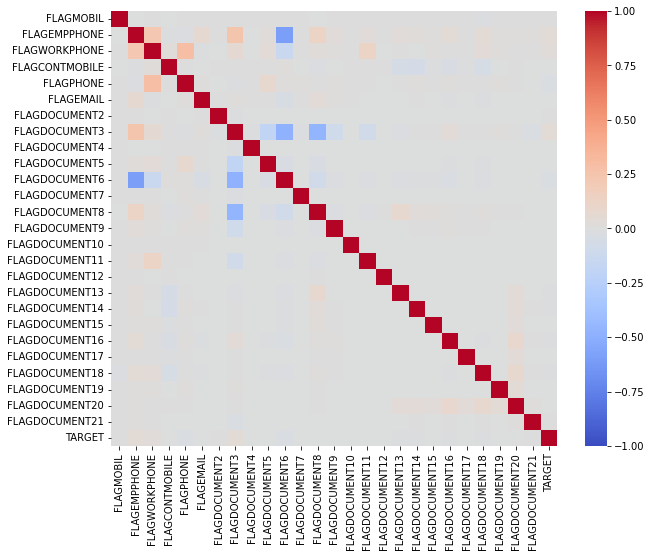

In [26]:
#matriz de correlação para medir essa correlação
plt.figure(figsize=(10,8))
sns.heatmap(df_flags.corr(), cmap='coolwarm', vmin=-1, vmax=1)

### Conclusão

Todas as colunas FLAG_DOCUMENT_* serão retiradas por não terem informações que pareçam relevantes para análise

FLAG_MOBIL, FLAG_CONT_MOBILE tem muito poucos registro False, então também são irrelevantes



In [27]:
df.drop(cols_flags, inplace=True, axis=1)

## Conclusão Análise Exploratória

* Analisar melhor valores nulos das colunas
* DAYS_EMPLOYED foi alterado recebendo valor zero onde era negativo
* CODE_GENDER retirado para atender questões éticas
* Atributos de FLAGS se mostraram muito irrelevantes já na análise inicial e foram retirados do estudos
* Mudança nos nomes das colunas para evitar erros nos algoritmos

In [28]:
df.head()

,SKIDCURR,TARGET,CNTCHILDREN,DAYSBIRTH,DAYSEMPLOYED,DAYSREGISTRATION,DAYSIDPUBLISH,OWNCARAGE,CNTFAMMEMBERS,REGIONRATINGCLIENT,...,ELEVATORSMEDI,ENTRANCESMEDI,FLOORSMAXMEDI,FLOORSMINMEDI,LANDAREAMEDI,LIVINGAPARTMENTSMEDI,LIVINGAREAMEDI,NONLIVINGAPARTMENTSMEDI,NONLIVINGAREAMEDI,TOTALAREAMODE
0,336639,1,1,12226,496,4292,4668,11.0,3.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,289004,0,1,11562,710,1030,3558,NaN,3.0,3,...,0.2,0.1724,0.3333,0.375,0.0242,0.1539,0.1987,0.0039,0.0296,0.1703
2,240024,0,0,16427,3385,2208,4032,11.0,2.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,347406,1,2,12069,753,5961,3148,NaN,4.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,302895,0,2,13359,469,1404,4364,11.0,3.0,2,...,NaN,0.1379,0.1667,NaN,NaN,NaN,0.0696,NaN,NaN,0.0537


In [29]:
print('DataFrame pós análise exploratória: '+str(df.shape))

DataFrame pós análise exploratória: (246008, 95)


# Separação dos dados

## Categorização

Os testes serão feitos com 2 tipos de categorização. A primeira bateria de testes vai ter LabelEncoder em todas as colunas e a segunda terá GetDummys nas colunas em que o número de opções não seja muito grande

### Label Encoder

In [30]:
df_label = df[df.select_dtypes('object').columns].apply(LabelEncoder().fit_transform)

In [31]:
df_label.shape

(246008, 15)

In [32]:
df_label = pd.concat([df_label, df.select_dtypes(exclude='object')], axis=1)

In [33]:
df_label.shape

(246008, 95)

In [34]:
df_label = df_label.fillna(0)

### Get Dummys

In [35]:
df_dummys= pd.get_dummies(df, columns=['NAMECONTRACTTYPE','NAMETYPESUITE','NAMEINCOMETYPE','NAMEFAMILYSTATUS','NAMEHOUSINGTYPE','FONDKAPREMONTMODE','HOUSETYPEMODE','FLAGOWNCAR','FLAGOWNREALTY','WEEKDAYAPPRPROCESSSTART','NAMEEDUCATIONTYPE','WALLSMATERIALMODE','EMERGENCYSTATEMODE'])

#retirada de underline dos nomes das colunas para não dar erros nos algoritmos
df_dummys = df_dummys.rename(columns = lambda x:re.sub('[^A-Za-z0-9]+', '', x)) 


In [36]:
df_dummys.select_dtypes('object')

,OCCUPATIONTYPE,ORGANIZATIONTYPE
0,Low-skill Laborers,Industry: type 11
1,Managers,Business Entity Type 3
2,Laborers,Self-employed
3,Managers,Services
4,Managers,Other
...,...,...
246003,Sales staff,Business Entity Type 3
246004,NaN,XNA
246005,Laborers,Business Entity Type 3
246006,Laborers,Self-employed


In [37]:
df_dummys_label = df_dummys[df_dummys.select_dtypes('object').columns].apply(LabelEncoder().fit_transform)

In [38]:
df_dummys_label

,OCCUPATIONTYPE,ORGANIZATIONTYPE
0,9,16
1,10,5
2,8,42
3,10,43
4,10,33
...,...,...
246003,14,5
246004,18,57
246005,8,5
246006,8,42


In [39]:
df_dummys_encoded = pd.concat([df_dummys_label, df_dummys.select_dtypes(exclude='object')], axis=1)

In [40]:
df_dummys_encoded.describe()

,OCCUPATIONTYPE,ORGANIZATIONTYPE,SKIDCURR,TARGET,CNTCHILDREN,DAYSBIRTH,DAYSEMPLOYED,DAYSREGISTRATION,DAYSIDPUBLISH,OWNCARAGE,...,NAMEEDUCATIONTYPESecondarysecondaryspecial,WALLSMATERIALMODEBlock,WALLSMATERIALMODEMixed,WALLSMATERIALMODEMonolithic,WALLSMATERIALMODEOthers,WALLSMATERIALMODEPanel,WALLSMATERIALMODEStonebrick,WALLSMATERIALMODEWooden,EMERGENCYSTATEMODENo,EMERGENCYSTATEMODEYes
count,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,83649.000000,...,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.00000
mean,11.039844,29.436982,278280.072908,0.081176,0.415527,16042.794393,1954.523207,4988.033300,2991.647642,12.034346,...,0.710672,0.030007,0.007528,0.005801,0.005223,0.214704,0.210627,0.017329,0.517768,0.00761
std,5.955194,20.470311,102790.909988,0.273106,0.719922,4365.973763,2306.666246,3520.987047,1510.020637,11.861705,...,0.453451,0.170607,0.086438,0.075941,0.072084,0.410618,0.407755,0.130493,0.499685,0.08690
min,0.000000,0.000000,100002.000000,0.000000,0.000000,7489.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,6.000000,5.000000,189165.500000,0.000000,0.000000,12418.000000,289.000000,2018.000000,1715.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,10.000000,33.000000,278392.500000,0.000000,0.000000,15763.000000,1215.000000,4503.000000,3250.000000,9.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000
75%,18.000000,47.000000,367272.250000,0.000000,1.000000,19691.000000,2758.000000,7481.000000,4297.250000,15.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000
max,18.000000,57.000000,456255.000000,1.000000,19.000000,25229.000000,17912.000000,23738.000000,7197.000000,91.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [41]:
df_dummys_encoded = df_dummys_encoded.fillna(0)

## Separação Treino/teste

A separação dos dados considera as duas situações de categorização

**20% dos dados será separado para validação final dos modelos, sem que participe dos treinamentos**

In [42]:
X, X_final, y, y_final = train_test_split(df_label.drop('TARGET', axis=1), 
                                          df_label['TARGET'], 
                                          test_size=0.2, random_state=81)

In [43]:
Xd, X_finald, yd, y_finald = train_test_split(df_dummys_encoded.drop('TARGET', axis=1), 
                                          df_dummys_encoded['TARGET'], 
                                          test_size=0.2, random_state=81)

In [44]:
X.shape, X_final.shape, Xd.shape, X_finald.shape

((196806, 94), (49202, 94), (196806, 142), (49202, 142))

**Dados de treino e teste separados na proporção de 70/30**

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=81)

In [46]:
X_traind, X_testd, y_traind, y_testd = train_test_split(Xd, yd, test_size=0.3, random_state=81)

In [47]:
X_train.shape, X_test.shape, X_traind.shape, X_testd.shape

((137764, 94), (59042, 94), (137764, 142), (59042, 142))

In [48]:
X_final.to_csv('X_final.csv')
y_final.to_csv('y_final.csv')
X_finald.to_csv('X_finald.csv')
y_finald.to_csv('y_finald.csv')
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')
X_traind.to_csv('X_traind.csv')
X_testd.to_csv('X_testd.csv')
y_traind.to_csv('y_traind.csv')
y_testd.to_csv('y_testd.csv')

## Colunas CHI2

In [49]:
sb = SelectKBest(score_func=chi2, k=20, )

sb.fit(df_label.drop(['TARGET','SKIDCURR'],axis=1), df_label['TARGET'])


SelectKBest(k=20, score_func=<function chi2 at 0x0000016A45603A60>)

In [50]:
cols_chi2 = sb.get_feature_names_out()
print(cols_chi2)

['NAMEINCOMETYPE' 'NAMEEDUCATIONTYPE' 'ORGANIZATIONTYPE' 'HOUSETYPEMODE'
 'EMERGENCYSTATEMODE' 'DAYSBIRTH' 'DAYSEMPLOYED' 'DAYSREGISTRATION'
 'DAYSIDPUBLISH' 'REGCITYNOTLIVECITY' 'REGCITYNOTWORKCITY'
 'DEF30CNTSOCIALCIRCLE' 'DAYSLASTPHONECHANGE' 'AMTINCOMETOTAL' 'AMTCREDIT'
 'AMTANNUITY' 'AMTGOODSPRICE' 'EXTSOURCE1' 'EXTSOURCE2' 'EXTSOURCE3']


In [51]:
sbd = SelectKBest(score_func=chi2, k=20, )

sbd.fit(df_dummys_encoded.drop(['TARGET','SKIDCURR'],axis=1), df_dummys_encoded['TARGET'])


SelectKBest(k=20, score_func=<function chi2 at 0x0000016A45603A60>)

In [52]:
cols_chi2d = sbd.get_feature_names_out()
print(cols_chi2d)

['OCCUPATIONTYPE' 'ORGANIZATIONTYPE' 'DAYSBIRTH' 'DAYSEMPLOYED'
 'DAYSREGISTRATION' 'DAYSIDPUBLISH' 'REGCITYNOTLIVECITY'
 'REGCITYNOTWORKCITY' 'DEF30CNTSOCIALCIRCLE' 'DAYSLASTPHONECHANGE'
 'AMTINCOMETOTAL' 'AMTCREDIT' 'AMTANNUITY' 'AMTGOODSPRICE' 'EXTSOURCE1'
 'EXTSOURCE2' 'EXTSOURCE3' 'NAMEINCOMETYPEPensioner'
 'NAMEINCOMETYPEWorking' 'NAMEEDUCATIONTYPEHighereducation']


# Modelagem 1

* Colunas: todas
* DataCleaning: Preenchimento de valor ZERO para valores ausentes
* Categorização: LabelEnconder
* Balanceamento: Sem Balanceamento

## Tratamento de dados

## Algoritmos

### RandomForest

In [53]:
%%time

mdl = RandomForestClassifier(max_depth=5)

dados_modelo = executaAlgoritmo(mdl, X_train, y_train, X_test, y_test)



fit_time : [12.16594815 11.14880395 12.29853439 11.50898933 10.53966618]
score_time : [0.19903946 0.19899535 0.18904161 0.18604302 0.19104528]
test_score : [0.7170546  0.71027407 0.72209565 0.72177946 0.72659209]
train_score : [0.73742696 0.73971363 0.7367251  0.7362665  0.73623011]


ROC_AUC:
0.7186129968876337

Matriz de Confusão:
[[54231     0]
 [ 4811     0]]


Wall time: 1min 17s


In [54]:
roc_final, cv_final = avalicaoModelo(mdl, X_final, y_final)

ROC_AUC:
0.7150876642370225

Matriz de Confusão:
[[45288     0]
 [ 3914     0]]


#### Inserção tabela de controle

In [55]:
nome = 'RandomForest_Mod1'

lista_modelos= lista_modelos.append({'id_modelo':'3.2.1',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'RandomForest',
                      'roc_auc':roc_auc_score(y_test, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'todas',
                      'metodo_balanceamento':'sem',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'labelEnconder',
                      'confusao': confusion_matrix(y_test, dados_modelo[1]),
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,


                                    },
                    ignore_index=True)

In [56]:
with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

### LGBM

In [57]:
%%time

mdl = LGBMClassifier()

dados_modelo = executaAlgoritmo(mdl, X_train, y_train, X_test, y_test)


fit_time : [1.98403382 1.562006   1.34139109 1.3370111  1.43385291]
score_time : [0.08802009 0.07101583 0.0640142  0.06004739 0.07001495]
test_score : [0.75138738 0.73459583 0.74147566 0.75499493 0.75215256]
train_score : [0.83744161 0.83750871 0.83576443 0.83799834 0.83576036]


ROC_AUC:
0.7468589843854518

Matriz de Confusão:
[[54147    84]
 [ 4725    86]]


Wall time: 11.1 s


In [58]:
roc_final, cv_final = avalicaoModelo(mdl, X_final, y_final)

ROC_AUC:
0.7494568684227225

Matriz de Confusão:
[[45232    56]
 [ 3843    71]]


#### Inserção tabela de controle

In [59]:
nome = 'LGBM_Mod1'


lista_modelos= lista_modelos.append({'id_modelo':'3.2.2',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'LGBM',
                      'roc_auc':roc_auc_score(y_test, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'todas',
                      'metodo_balanceamento':'sem',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'labelEnconder',
                      'confusao': confusion_matrix(y_test, dados_modelo[1]),
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,
                                    },
                    ignore_index=True)

In [60]:
with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

### XGB

In [61]:
%%time


mdl = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

dados_modelo = executaAlgoritmo(mdl, X_train, y_train, X_test, y_test)


fit_time : [8.14108539 8.9199729  9.4705863  8.64138961 9.30235648]
score_time : [0.04400921 0.05502343 0.0570128  0.041008   0.0680151 ]
test_score : [0.73691334 0.72076572 0.72537652 0.73695538 0.73779669]
train_score : [0.90961526 0.90478011 0.9070184  0.90706247 0.90610333]


ROC_AUC:
0.7366408857839364

Matriz de Confusão:
[[54045   186]
 [ 4640   171]]


Wall time: 59.1 s


In [62]:
roc_final, cv_final = avalicaoModelo(mdl, X_final, y_final)


ROC_AUC:
0.7380655645124821

Matriz de Confusão:
[[45142   146]
 [ 3785   129]]


#### Inserção tabela de controle

In [63]:
nome = 'XGB_Mod1'


lista_modelos= lista_modelos.append({'id_modelo':'3.2.3',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'XGB',
                      'roc_auc':roc_auc_score(y_test, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'todas',
                      'metodo_balanceamento':'sem',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'labelEnconder',
                      'confusao': confusion_matrix(y_test, dados_modelo[1]),       
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,
                                    
                                    },
                    ignore_index=True)

In [64]:
with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

# Modelagem 2

* Colunas: todas
* DataCleaning: Preenchimento de valor ZERO para valores ausentes
* Categorização: LabelEnconder
* Balanceamento: NearMiss Balanceamento

## Tratamento de dados

In [65]:
y_train.value_counts()

0    126519
1     11245
Name: TARGET, dtype: int64

In [66]:
X_nm, y_nm = NearMiss().fit_resample(X_train, y_train)

In [67]:
X_train.shape, y_train.shape, X_nm.shape, y_nm.shape

((137764, 94), (137764,), (22490, 94), (22490,))

In [68]:
y_nm.value_counts()

0    11245
1    11245
Name: TARGET, dtype: int64

## Algoritmos

### RandomForest

In [69]:
%%time

mdl = RandomForestClassifier(max_depth=5)

dados_modelo = executaAlgoritmo(mdl, X_nm, y_nm, X_test, y_test)


fit_time : [1.89660501 1.80139828 2.01099229 1.77998209 1.63888669]
score_time : [0.04699683 0.04601026 0.04000998 0.04199505 0.03600788]
test_score : [0.86716926 0.8087444  0.81397473 0.79611313 0.76866829]
train_score : [0.81875418 0.83032908 0.83599371 0.83352823 0.83880978]


ROC_AUC:
0.5430307269945847

Matriz de Confusão:
[[19516 34715]
 [ 1263  3548]]


Wall time: 13.1 s


In [70]:
roc_final, cv_final = avalicaoModelo(mdl, X_final, y_final)


ROC_AUC:
0.5373236844858325

Matriz de Confusão:
[[16232 29056]
 [ 1066  2848]]


#### Inserção tabela de controle

In [71]:
nome = 'RandomForest_Mod2'


lista_modelos= lista_modelos.append({'id_modelo':'4.2.1',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'RandomForest',
                      'roc_auc':roc_auc_score(y_test, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'todas',
                      'metodo_balanceamento':'NearMiss',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'labelEnconder',
                      'confusao': confusion_matrix(y_test, dados_modelo[1]),   
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,
                                    
                                    },
                    ignore_index=True)

In [72]:
with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

### LGBM

In [73]:
%%time


mdl = LGBMClassifier()

dados_modelo = executaAlgoritmo(mdl, X_nm, y_nm, X_test, y_test)



fit_time : [0.61804914 0.71029115 0.5567677  0.65514898 0.65014577]
score_time : [0.02200484 0.02110195 0.02100325 0.02100444 0.01800394]
test_score : [0.9285789  0.91211133 0.90550061 0.89468863 0.86287686]
train_score : [0.94873363 0.95016645 0.95161962 0.95352208 0.95706251]


ROC_AUC:
0.5473603892225418

Matriz de Confusão:
[[14611 39620]
 [  977  3834]]


Wall time: 4.49 s


In [74]:
roc_final, cv_final = avalicaoModelo(mdl, X_final, y_final)


ROC_AUC:
0.5423986368014593

Matriz de Confusão:
[[12206 33082]
 [  834  3080]]


#### Inserção tabela de controle

In [75]:
nome = 'LGBM_Mod2'



lista_modelos= lista_modelos.append({'id_modelo':'4.2.2',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'LGBM',
                      'roc_auc':roc_auc_score(y_test, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'todas',
                      'metodo_balanceamento':'NearMiss',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'labelEnconder',
                      'confusao': confusion_matrix(y_test, dados_modelo[1]),
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,

                                    },
                    ignore_index=True)

In [76]:
with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

### XGB

In [77]:
%%time


mdl = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

dados_modelo = executaAlgoritmo(mdl, X_nm, y_nm, X_test, y_test)



fit_time : [1.82041049 1.79883933 1.8744216  1.68289471 1.58435893]
score_time : [0.01600337 0.01700306 0.01500344 0.01400352 0.01400089]
test_score : [0.92171631 0.90465146 0.89787072 0.88956467 0.85917658]
train_score : [0.98540264 0.98746517 0.98743159 0.98716528 0.98953982]


ROC_AUC:
0.5426203712709737

Matriz de Confusão:
[[14130 40101]
 [  947  3864]]


Wall time: 11.4 s


In [78]:
roc_final, cv_final = avalicaoModelo(mdl, X_final, y_final)


ROC_AUC:
0.5362005540061688

Matriz de Confusão:
[[11733 33555]
 [  809  3105]]


#### Inserção tabela de controle

In [79]:
nome = 'XGB_Mod2'



lista_modelos= lista_modelos.append({'id_modelo':'4.2.3',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'XGB',
                      'roc_auc':roc_auc_score(y_test, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'todas',
                      'metodo_balanceamento':'NearMiss',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'labelEnconder',
                      'confusao': confusion_matrix(y_test, dados_modelo[1]),
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,
                                
                                    },
                    ignore_index=True)

In [80]:
with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

# Modelagem 3

* Colunas: todas
* DataCleaning: Preenchimento de valor ZERO para valores ausentes
* Categorização: LabelEnconder
* Balanceamento: SMOTE Balanceamento

## Tratamento de dados

In [81]:
y_train.value_counts()

0    126519
1     11245
Name: TARGET, dtype: int64

In [82]:
X_smote, y_smote = SMOTE().fit_resample(X_train, y_train)

In [83]:
X_train.shape, y_train.shape, X_smote.shape, y_smote.shape

((137764, 94), (137764,), (253038, 94), (253038,))

In [84]:
y_smote.value_counts()

0    126519
1    126519
Name: TARGET, dtype: int64

## Algoritmos

### RandomForest

In [85]:
%%time

mdl = RandomForestClassifier(max_depth=5)

dados_modelo = executaAlgoritmo(mdl, X_smote, y_smote, X_test, y_test)


fit_time : [33.40561271 32.49723649 31.46515536 32.79348826 31.96325517]
score_time : [0.34467864 0.36107755 0.34507704 0.33358431 0.33914566]
test_score : [0.82353477 0.9666834  0.9659649  0.96817605 0.96645486]
train_score : [0.97371551 0.93294759 0.93280839 0.93402174 0.93231189]


ROC_AUC:
0.6562777513243778

Matriz de Confusão:
[[50112  4119]
 [ 3964   847]]


Wall time: 3min 35s


In [86]:
roc_final, cv_final = avalicaoModelo(mdl, X_final, y_final)


ROC_AUC:
0.6510947857969485

Matriz de Confusão:
[[41763  3525]
 [ 3277   637]]


#### Inserção tabela de controle

In [87]:
nome = 'RandomForest_Mod3'


lista_modelos= lista_modelos.append({'id_modelo':'5.2.1',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'RandomForest',
                      'roc_auc':roc_auc_score(y_test, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'todas',
                      'metodo_balanceamento':'SMOTE',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'labelEnconder',
                      'confusao': confusion_matrix(y_test, dados_modelo[1]),   
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,                                     
                                    
                                    },
                    ignore_index=True)

In [88]:
with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

### LGBM

In [89]:
%%time


mdl = LGBMClassifier()

dados_modelo = executaAlgoritmo(mdl, X_smote, y_smote,  X_test, y_test)



fit_time : [3.83943295 3.01776385 3.57971883 4.26329422 3.8814733 ]
score_time : [0.14403224 0.11902738 0.14103174 0.15054464 0.13203144]
test_score : [0.8393394  0.99976699 0.99982932 0.9997739  0.99967486]
train_score : [0.99999626 0.97521527 0.97506307 0.97519093 0.97510705]


ROC_AUC:
0.7395212925135175

Matriz de Confusão:
[[54046   185]
 [ 4667   144]]


Wall time: 27.2 s


In [90]:
roc_final, cv_final = avalicaoModelo(mdl, X_final, y_final)


ROC_AUC:
0.741226451059554

Matriz de Confusão:
[[45134   154]
 [ 3809   105]]


#### Inserção tabela de controle

In [91]:
nome = 'LGBM_Mod3'


lista_modelos= lista_modelos.append({'id_modelo':'5.2.2',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'LGBM',
                      'roc_auc':roc_auc_score(y_test, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'todas',
                      'metodo_balanceamento':'SMOTE',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'labelEnconder',
                      'confusao': confusion_matrix(y_test, dados_modelo[1]),
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,


                                    },
                    ignore_index=True)

In [92]:
with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

### XGB

In [93]:
%%time

mdl = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

dados_modelo = executaAlgoritmo(mdl,X_nm, y_nm, X_test, y_test)



fit_time : [2.00345063 1.98198271 1.67996311 1.79948974 1.74716783]
score_time : [0.01800561 0.01500416 0.01500392 0.01300311 0.01700521]
test_score : [0.92171631 0.90465146 0.89787072 0.88956467 0.85917658]
train_score : [0.98540264 0.98746517 0.98743159 0.98716528 0.98953982]


ROC_AUC:
0.5426203712709737

Matriz de Confusão:
[[14130 40101]
 [  947  3864]]


Wall time: 11.8 s


In [94]:
roc_final, cv_final = avalicaoModelo(mdl, X_final, y_final)


ROC_AUC:
0.5362005540061688

Matriz de Confusão:
[[11733 33555]
 [  809  3105]]


#### Inserção tabela de controle

In [95]:
nome = 'XGB_Mod3'


lista_modelos= lista_modelos.append({'id_modelo':'5.2.3',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'XGB',
                      'roc_auc':roc_auc_score(y_test, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'todas',
                      'metodo_balanceamento':'SMOTE',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'labelEnconder',
                      'confusao': confusion_matrix(y_test, dados_modelo[1]),
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,
                                
                                    },
                    ignore_index=True)

In [96]:
with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

# Modelagem 4

* Colunas: 20 melhores CHI2
* DataCleaning: Preenchimento de valor ZERO para valores ausentes
* Categorização: LabelEnconder
* Balanceamento: Sem Balanceamento

## Tratamento de dados

## Algoritmos

### RandomForest

In [97]:
%%time

mdl = RandomForestClassifier(max_depth=5)

dados_modelo = executaAlgoritmo(mdl, X_train[cols_chi2], y_train, X_test[cols_chi2], y_test)



fit_time : [9.44147372 9.0804646  8.56437206 9.01134515 9.04658937]
score_time : [0.19104767 0.18504119 0.18354917 0.17712903 0.20102763]
test_score : [0.72280874 0.71670119 0.72715547 0.73128607 0.73274055]
train_score : [0.73661194 0.74015073 0.73824654 0.73710018 0.73906104]


ROC_AUC:
0.7250900950318222

Matriz de Confusão:
[[54231     0]
 [ 4811     0]]


Wall time: 1min 3s


In [98]:
roc_final, cv_final = avalicaoModelo(mdl, X_final[cols_chi2], y_final)


ROC_AUC:
0.7233113540890677

Matriz de Confusão:
[[45288     0]
 [ 3914     0]]


#### Inserção tabela de controle

In [99]:
nome = 'RandomForest_Mod4'



lista_modelos= lista_modelos.append({'id_modelo':'6.2.1',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'RandomForest',
                      'roc_auc':roc_auc_score(y_test, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'Top20 Chi2',
                      'metodo_balanceamento':'sem',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'labelEnconder',
                      'confusao': confusion_matrix(y_test, dados_modelo[1]),        
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,
                                     
                                    },
                    ignore_index=True)

In [100]:

with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

### LGBM

In [101]:
%%time

mdl = LGBMClassifier()

dados_modelo = executaAlgoritmo(mdl, X_train[cols_chi2], y_train, X_test[cols_chi2], y_test)


fit_time : [0.59913063 0.598665   0.55112314 0.57865834 0.58915019]
score_time : [0.05055881 0.04800868 0.03800917 0.03800845 0.03700781]
test_score : [0.74595195 0.73404239 0.74032027 0.75479489 0.74751638]
train_score : [0.82304495 0.82254381 0.82464525 0.82297065 0.82163701]


ROC_AUC:
0.7428815878476017

Matriz de Confusão:
[[54167    64]
 [ 4745    66]]


Wall time: 4.76 s


In [102]:
roc_final, cv_final = avalicaoModelo(mdl, X_final[cols_chi2], y_final)


ROC_AUC:
0.7466102990934667

Matriz de Confusão:
[[45239    49]
 [ 3857    57]]


#### Inserção tabela de controle

In [103]:
nome = 'LGBM_Mod4'



lista_modelos= lista_modelos.append({'id_modelo':'6.2.2',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'LGBM',
                      'roc_auc':roc_auc_score(y_test, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'Top20 Chi2',
                      'metodo_balanceamento':'sem',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'labelEnconder',
                      'confusao': confusion_matrix(y_test, dados_modelo[1]),                                    
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,
                                     
                                    },
                    ignore_index=True)

In [104]:
with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

### XGB

In [105]:
%%time


mdl = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

dados_modelo = executaAlgoritmo(mdl, X_train[cols_chi2], y_train, X_test[cols_chi2], y_test)


fit_time : [5.57473207 6.57231712 6.6828177  6.60392165 6.02371216]
score_time : [0.02700639 0.03000736 0.03200746 0.04251766 0.03600788]
test_score : [0.74262158 0.72352506 0.72968353 0.74176672 0.73817651]
train_score : [0.88286768 0.88576943 0.88460986 0.88359636 0.88373039]


ROC_AUC:
0.7345392480869145

Matriz de Confusão:
[[54048   183]
 [ 4673   138]]


Wall time: 38.7 s


In [106]:
roc_final, cv_final = avalicaoModelo(mdl, X_final[cols_chi2], y_final)


ROC_AUC:
0.7347951591616866

Matriz de Confusão:
[[45139   149]
 [ 3796   118]]


#### Inserção tabela de controle

In [107]:
nome = 'XGB_Mod4'


lista_modelos= lista_modelos.append({'id_modelo':'6.2.3',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'XGB',
                      'roc_auc':roc_auc_score(y_test, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'Top20 Chi2',
                      'metodo_balanceamento':'sem',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'labelEnconder',
                      'confusao': confusion_matrix(y_test, dados_modelo[1]),      
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,
                                    
                                    },
                    ignore_index=True)

In [108]:
with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

# Modelagem 5


* Colunas: 20 melhores CHI2
* DataCleaning: Preenchimento de valor ZERO para valores ausentes
* Categorização: LabelEnconder
* Balanceamento: NearMiss Balanceamento

## Tratamento de dados

In [109]:
y_train.value_counts()

0    126519
1     11245
Name: TARGET, dtype: int64

In [110]:
X_nm, y_nm = NearMiss().fit_resample(X_train[cols_chi2], y_train)

In [111]:
X_train.shape, y_train.shape, X_nm.shape, y_nm.shape

((137764, 94), (137764,), (22490, 20), (22490,))

In [112]:
y_nm.value_counts()

0    11245
1    11245
Name: TARGET, dtype: int64

## Algoritmos

### RandomForest

In [113]:
%%time

mdl = RandomForestClassifier(max_depth=5)

dados_modelo = executaAlgoritmo(mdl, X_nm, y_nm, X_test[cols_chi2], y_test)


fit_time : [1.74839091 1.60836983 1.72338986 1.52834177 1.53736091]
score_time : [0.05802226 0.0469954  0.05101109 0.04200149 0.04099321]
test_score : [0.90775664 0.86679154 0.83590929 0.81403246 0.76045438]
train_score : [0.83671514 0.85775598 0.8629336  0.86674832 0.87402006]


ROC_AUC:
0.5160395489948977

Matriz de Confusão:
[[12177 42054]
 [  934  3877]]


Wall time: 12.1 s


In [114]:
roc_final, cv_final = avalicaoModelo(mdl, X_final[cols_chi2], y_final)


ROC_AUC:
0.5095037843082193

Matriz de Confusão:
[[10386 34902]
 [  793  3121]]


#### Inserção tabela de controle

In [115]:
nome = 'RandomForest_Mod5'



lista_modelos= lista_modelos.append({'id_modelo':'7.2.1',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'RandomForest',
                      'roc_auc':roc_auc_score(y_test, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'Top20 Chi2',
                      'metodo_balanceamento':'NearMiss',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'labelEnconder',
                      'confusao': confusion_matrix(y_test, dados_modelo[1]),                                    
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,
                                    
                                    },
                    ignore_index=True)

In [116]:
with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

### LGBM

In [117]:
%%time


mdl = LGBMClassifier()

dados_modelo = executaAlgoritmo(mdl, X_nm, y_nm, X_test[cols_chi2], y_test)



fit_time : [0.30806804 0.30106664 0.27171516 0.28375912 0.29000878]
score_time : [0.01600337 0.01600313 0.01300406 0.01523376 0.01400328]
test_score : [0.92390175 0.93264078 0.91808859 0.90639029 0.86403502]
train_score : [0.94987555 0.95189479 0.95505844 0.95568509 0.96118752]


ROC_AUC:
0.5179805153931287

Matriz de Confusão:
[[10613 43618]
 [  876  3935]]


Wall time: 2.26 s


In [118]:
roc_final, cv_final = avalicaoModelo(mdl, X_final[cols_chi2], y_final)


ROC_AUC:
0.5096586129698787

Matriz de Confusão:
[[ 8892 36396]
 [  741  3173]]


#### Inserção tabela de controle

In [119]:
nome = 'LGBM_Mod5'


lista_modelos= lista_modelos.append({'id_modelo':'7.2.2',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'LGBM',
                      'roc_auc':roc_auc_score(y_test, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'Top20 Chi2',
                      'metodo_balanceamento':'NearMiss',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'labelEnconder',
                      'confusao': confusion_matrix(y_test, dados_modelo[1]),
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,

                                    },
                    ignore_index=True)

In [120]:
with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

### XGB

In [121]:
%%time


mdl = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

dados_modelo = executaAlgoritmo(mdl, X_nm, y_nm, X_test[cols_chi2], y_test)



fit_time : [1.18326306 1.15225887 1.12025166 1.09524655 1.27028418]
score_time : [0.01400304 0.01500368 0.01200318 0.01000309 0.01300383]
test_score : [0.90781833 0.93001494 0.91601366 0.90668962 0.86124044]
train_score : [0.98362699 0.98219886 0.98349051 0.98561212 0.98535828]


ROC_AUC:
0.5123158383331063

Matriz de Confusão:
[[10455 43776]
 [  862  3949]]


Wall time: 7.83 s


In [122]:
roc_final, cv_final = avalicaoModelo(mdl, X_final[cols_chi2], y_final)


ROC_AUC:
0.5044381743476621

Matriz de Confusão:
[[ 8829 36459]
 [  747  3167]]


#### Inserção tabela de controle

In [123]:
nome = 'XGB_Mod5'



lista_modelos= lista_modelos.append({'id_modelo':'7.2.3',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'XGB',
                      'roc_auc':roc_auc_score(y_test, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'Top20 Chi2',
                      'metodo_balanceamento':'NearMiss',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'labelEnconder',
                      'confusao': confusion_matrix(y_test, dados_modelo[1]),
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,
                                
                                    },
                    ignore_index=True)

In [124]:
with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

# Modelagem 6

* Colunas: todas
* DataCleaning: Preenchimento de valor ZERO para valores ausentes
* Categorização: LabelEnconder
* Balanceamento: SMOTE Balanceamento

## Tratamento de dados

In [125]:
y_train.value_counts()

0    126519
1     11245
Name: TARGET, dtype: int64

In [126]:
X_smote, y_smote = SMOTE().fit_resample(X_train[cols_chi2], y_train)

In [127]:
X_train.shape, y_train.shape, X_smote.shape, y_smote.shape

((137764, 94), (137764,), (253038, 20), (253038,))

In [128]:
y_smote.value_counts()

0    126519
1    126519
Name: TARGET, dtype: int64

## Algoritmos

### RandomForest

In [129]:
%%time

mdl = RandomForestClassifier(max_depth=5)

dados_modelo = executaAlgoritmo(mdl, X_smote, y_smote, X_test[cols_chi2], y_test)


fit_time : [21.42396903 19.80433989 21.2775166  22.28870916 20.9161675 ]
score_time : [0.31219602 0.31559038 0.39710283 0.32607841 0.31006813]
test_score : [0.79817001 0.89718848 0.90456957 0.89495727 0.90124734]
train_score : [0.90694956 0.87303699 0.88050316 0.87395064 0.87695888]


ROC_AUC:
0.6786336370936922

Matriz de Confusão:
[[41592 12639]
 [ 2509  2302]]


Wall time: 2min 24s


In [130]:
roc_final, cv_final = avalicaoModelo(mdl, X_final[cols_chi2], y_final)


ROC_AUC:
0.6705296684312435

Matriz de Confusão:
[[34785 10503]
 [ 2136  1778]]


#### Inserção tabela de controle

In [131]:
nome = 'RandomForest_Mod6'



lista_modelos= lista_modelos.append({'id_modelo':'8.2.1',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'RandomForest',
                      'roc_auc':roc_auc_score(y_test, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'Top20 Chi2',
                      'metodo_balanceamento':'SMOTE',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'labelEnconder',
                      'confusao': confusion_matrix(y_test, dados_modelo[1]),     
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,
                                    
                                    },
                    ignore_index=True)

In [132]:
with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

### LGBM

In [133]:
%%time


mdl = LGBMClassifier()

dados_modelo = executaAlgoritmo(mdl, X_smote, y_smote, X_test[cols_chi2], y_test)



fit_time : [1.29894805 1.21927309 1.13931751 1.01531315 1.05723572]
score_time : [0.14703488 0.08101821 0.07901764 0.07801771 0.08001828]
test_score : [0.84234482 0.98346646 0.98382413 0.98348456 0.98431638]
train_score : [0.9873703  0.95761438 0.957466   0.95781998 0.95722264]


ROC_AUC:
0.7030758714901126

Matriz de Confusão:
[[51441  2790]
 [ 4011   800]]


Wall time: 9.35 s


In [134]:
roc_final, cv_final = avalicaoModelo(mdl, X_final[cols_chi2], y_final)


ROC_AUC:
0.7047346987794552

Matriz de Confusão:
[[43019  2269]
 [ 3255   659]]


#### Inserção tabela de controle

In [135]:
nome = 'LGBM_Mod6'



lista_modelos= lista_modelos.append({'id_modelo':'8.2.2',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'LGBM',
                      'roc_auc':roc_auc_score(y_test, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'Top20 Chi2',
                      'metodo_balanceamento':'SMOTE',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'labelEnconder',
                      'confusao': confusion_matrix(y_test, dados_modelo[1]),
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,

                                    },
                    ignore_index=True)

In [136]:
with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

### XGB

In [137]:
%%time


mdl = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

dados_modelo = executaAlgoritmo(mdl, X_smote, y_smote, X_test[cols_chi2], y_test)



fit_time : [10.04826903 14.37625527 10.31945944  9.48986268  9.72507906]
score_time : [0.04601002 0.05320954 0.04369211 0.04801083 0.05494189]
test_score : [0.84802943 0.98988568 0.99006105 0.98945074 0.99018397]
train_score : [0.99448896 0.97279227 0.97219459 0.97184774 0.97149583]


ROC_AUC:
0.6980777043579188

Matriz de Confusão:
[[51609  2622]
 [ 4023   788]]


Wall time: 1min 7s


In [138]:
roc_final, cv_final = avalicaoModelo(mdl, X_final[cols_chi2], y_final)


ROC_AUC:
0.7044407897557601

Matriz de Confusão:
[[43175  2113]
 [ 3254   660]]


#### Inserção tabela de controle

In [139]:
nome = 'XGB_Mod6'



lista_modelos= lista_modelos.append({'id_modelo':'8.2.3',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'XGB',
                      'roc_auc':roc_auc_score(y_test, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'Top20 Chi2',
                      'metodo_balanceamento':'SMOTE',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'labelEnconder',
                      'confusao': confusion_matrix(y_test, dados_modelo[1]),
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,
                                
                                    },
                    ignore_index=True)

In [140]:
with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

# ----- Melhores até aqui ------

A análise seguira com dados onde a categorização considerou GetDummys para algumas colunas. A análise será repetindo as cofigurações de colunas e balanceamento dos melhores modelos identificados até aqui.

São eles:
* 3.2.2	LGBM_Mod1
* 5.2.2	LGBM_Mod3
* 6.2.2	LGBM_Mod4
* 6.2.3	XGB_Mod4
* 8.2.2	LGBM_Mod6
* 8.2.3	XGB_Mod6




# Modelagem 7

* Colunas: todas
* DataCleaning: Preenchimento de valor ZERO para valores ausentes
* Categorização: GetDummys
* Balanceamento: Sem Balanceamento

## Tratamento de dados

## Algoritmos

### LGBM

In [141]:
%%time

mdl = LGBMClassifier()

dados_modelo = executaAlgoritmo(mdl, X_traind, y_traind, X_testd, y_testd)


fit_time : [1.79678321 1.54614639 1.47287774 1.50625205 1.49854279]
score_time : [0.06400704 0.07223582 0.06400585 0.0640049  0.06400418]
test_score : [0.75103725 0.73410153 0.74438376 0.75496429 0.7498055 ]
train_score : [0.83808795 0.83914957 0.83815776 0.83547209 0.83768619]


ROC_AUC:
0.7465899136192846

Matriz de Confusão:
[[54173    58]
 [ 4743    68]]


Wall time: 11.8 s


In [142]:
roc_final, cv_final = avalicaoModelo(mdl, X_finald, y_finald)


ROC_AUC:
0.7484506189287667

Matriz de Confusão:
[[45247    41]
 [ 3861    53]]


#### Inserção tabela de controle

In [143]:
nome = 'LGBM_Mod7'



lista_modelos= lista_modelos.append({'id_modelo':'.10.2.1',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'LGBM',
                      'roc_auc':roc_auc_score(y_testd, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'todas',
                      'metodo_balanceamento':'sem',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'GetDummys',
                      'confusao': confusion_matrix(y_testd, dados_modelo[1]),   
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,
                                     
                                    },
                    ignore_index=True)

In [144]:
with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

# Modelagem 8

* Colunas: todas
* DataCleaning: Preenchimento de valor ZERO para valores ausentes
* Categorização: GetDummys
* Balanceamento: SMOTE Balanceamento

## Tratamento de dados

In [145]:
y_traind.value_counts()

0    126519
1     11245
Name: TARGET, dtype: int64

In [146]:
X_smote, y_smote = SMOTE().fit_resample(X_traind, y_traind)

In [147]:
X_traind.shape, y_traind.shape, X_smote.shape, y_smote.shape

((137764, 142), (137764,), (253038, 142), (253038,))

In [148]:
y_smote.value_counts()

0    126519
1    126519
Name: TARGET, dtype: int64

## Algoritmos

### LGBM

In [149]:
%%time

mdl = LGBMClassifier()

dados_modelo = executaAlgoritmo(mdl, X_smote, y_smote, X_testd, y_testd)


fit_time : [4.08706093 3.05461168 3.08314133 3.47250772 3.03994226]
score_time : [0.13602066 0.13601041 0.13620877 0.13601351 0.1362865 ]
test_score : [0.8447187  0.99992141 0.99996713 0.9999613  0.99996269]
train_score : [1.         0.97660829 0.97657176 0.97662544 0.97669833]


ROC_AUC:
0.7468299240374692

Matriz de Confusão:
[[54104   127]
 [ 4706   105]]


Wall time: 24.9 s


In [150]:
roc_final, cv_final = avalicaoModelo(mdl, X_finald, y_finald)


ROC_AUC:
0.7479117354151169

Matriz de Confusão:
[[45202    86]
 [ 3836    78]]


#### Inserção tabela de controle

In [151]:
nome = 'LGBM_Mod8'



lista_modelos= lista_modelos.append({'id_modelo':'.11.2.1',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'LGBM',
                      'roc_auc':roc_auc_score(y_testd, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'todas',
                      'metodo_balanceamento':'SMOTE',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'GetDummys',
                      'confusao': confusion_matrix(y_testd, dados_modelo[1]),                                    
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,
                                     
                                    },
                    ignore_index=True)

In [152]:
with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

# Modelagem 9

* Colunas: 20 melhores CHI2
* DataCleaning: Preenchimento de valor ZERO para valores ausentes
* Categorização: GetDummys
* Balanceamento: Sem Balanceamento

## Tratamento de dados

## Algoritmos

### LGBM

In [153]:
%%time

mdl = LGBMClassifier()

dados_modelo = executaAlgoritmo(mdl, X_traind[cols_chi2d], y_traind, X_testd[cols_chi2d], y_testd)


fit_time : [0.680161   0.56007314 0.64776158 0.48835254 0.5731771 ]
score_time : [0.04800391 0.04000258 0.04000306 0.03943229 0.03462148]
test_score : [0.7460959  0.73203289 0.74145074 0.75482698 0.74909419]
train_score : [0.82411573 0.82469341 0.82458129 0.82227593 0.82220558]


ROC_AUC:
0.7429969131984921

Matriz de Confusão:
[[54164    67]
 [ 4745    66]]


Wall time: 4.8 s


In [154]:
roc_final, cv_final = avalicaoModelo(mdl, X_finald[cols_chi2d], y_finald)


ROC_AUC:
0.7467445390324047

Matriz de Confusão:
[[45250    38]
 [ 3862    52]]


#### Inserção tabela de controle

In [155]:
nome = 'LGBM_Mod9'



lista_modelos= lista_modelos.append({'id_modelo':'.12.2.1',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'LGBM',
                      'roc_auc':roc_auc_score(y_testd, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'todas',
                      'metodo_balanceamento':'sem',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'GetDummys',
                      'confusao': confusion_matrix(y_testd, dados_modelo[1]),    
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,
                                     
                                    },
                    ignore_index=True)

In [156]:
with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

### XGB

In [157]:
%%time

mdl = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

dados_modelo = executaAlgoritmo(mdl, X_traind[cols_chi2d], y_traind, X_testd[cols_chi2d], y_testd)


fit_time : [4.53269529 4.23507833 4.23856497 4.26591325 4.4461627 ]
score_time : [0.02400327 0.03200412 0.0320034  0.02400422 0.02400231]
test_score : [0.73809287 0.7216069  0.72624863 0.74718632 0.73744674]
train_score : [0.88230255 0.88280035 0.88883041 0.88439842 0.88678726]


ROC_AUC:
0.7341615133896395

Matriz de Confusão:
[[54045   186]
 [ 4657   154]]


Wall time: 27.7 s


In [158]:
roc_final, cv_final = avalicaoModelo(mdl, X_finald[cols_chi2d], y_finald)


ROC_AUC:
0.7390767305900389

Matriz de Confusão:
[[45155   133]
 [ 3796   118]]


#### Inserção tabela de controle

In [159]:
nome = 'XGB_Mod9'



lista_modelos= lista_modelos.append({'id_modelo':'12.2.2',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'XGB',
                      'roc_auc':roc_auc_score(y_testd, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'Top20 Chi2',
                      'metodo_balanceamento':'sem',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'GetDummys',
                      'confusao': confusion_matrix(y_testd, dados_modelo[1]),           
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,
                                    
                                    },
                    ignore_index=True)

In [160]:
with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

# Modelagem 10

* Colunas: todas
* DataCleaning: Preenchimento de valor ZERO para valores ausentes
* Categorização: LabelEnconder
* Balanceamento: SMOTE Balanceamento

## Tratamento de dados

In [161]:
y_traind.value_counts()

0    126519
1     11245
Name: TARGET, dtype: int64

In [162]:
X_smote, y_smote = SMOTE().fit_resample(X_traind[cols_chi2d], y_traind)

In [163]:
X_traind.shape, y_traind.shape, X_smote.shape, y_smote.shape

((137764, 142), (137764,), (253038, 20), (253038,))

In [164]:
y_smote.value_counts()

0    126519
1    126519
Name: TARGET, dtype: int64

## Algoritmos

### LGBM

In [165]:
%%time

mdl = LGBMClassifier()

dados_modelo = executaAlgoritmo(mdl, X_smote, y_smote, X_testd[cols_chi2d], y_testd)


fit_time : [1.16969347 1.09010458 0.97480297 1.06696391 1.04141831]
score_time : [0.1035285  0.08022451 0.08788633 0.08000708 0.07538056]
test_score : [0.83749819 0.97997166 0.98079113 0.98111194 0.98008068]
train_score : [0.9841415  0.95408556 0.95372155 0.95349276 0.95367554]


ROC_AUC:
0.6915457625683485

Matriz de Confusão:
[[50294  3937]
 [ 3816   995]]


Wall time: 9.17 s


In [166]:
roc_final, cv_final = avalicaoModelo(mdl, X_finald[cols_chi2d], y_finald)


ROC_AUC:
0.696598551194797

Matriz de Confusão:
[[42118  3170]
 [ 3119   795]]


#### Inserção tabela de controle

In [167]:
nome = 'LGBM_Mod10'



lista_modelos= lista_modelos.append({'id_modelo':'.13.2.1',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'LGBM',
                      'roc_auc':roc_auc_score(y_testd, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'todas',
                      'metodo_balanceamento':'SMOTE',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'GetDummys',
                      'confusao': confusion_matrix(y_testd, dados_modelo[1]),                                    
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,
                                     
                                    },
                    ignore_index=True)

In [168]:
with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

### XGB

In [169]:
%%time

mdl = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

dados_modelo = executaAlgoritmo(mdl, X_smote, y_smote, X_testd[cols_chi2d], y_testd)


fit_time : [ 8.98695564  8.64259291  8.61503053 10.27016306  8.91791606]
score_time : [0.05620599 0.05600357 0.04000282 0.04000473 0.04001069]
test_score : [0.84363903 0.98797633 0.98757553 0.9887083  0.98796626]
train_score : [0.99246164 0.96980583 0.96899998 0.96961382 0.96968665]


ROC_AUC:
0.688716611976142

Matriz de Confusão:
[[50713  3518]
 [ 3912   899]]


Wall time: 58.5 s


In [170]:
roc_final, cv_final = avalicaoModelo(mdl, X_finald[cols_chi2d], y_finald)


ROC_AUC:
0.6959787739436212

Matriz de Confusão:
[[42520  2768]
 [ 3156   758]]


#### Inserção tabela de controle

In [171]:
nome = 'XGB_Mod10'

lista_modelos= lista_modelos.append({'id_modelo':'13.2.2',
                      'nome_modelo':nome,
                      'data_treino':'09/03/2022',
                      'metodo':'XGB',
                      'roc_auc':roc_auc_score(y_testd, dados_modelo[2][:,1]),
                      'tempo_de_treino':dados_modelo[3]['fit_time'].mean(),
                      'hyperparametros':dados_modelo[0].get_params(),
                      'path_to_pickle': ''+nome+'.pkl',
                      'colunas_selection':'Top20 Chi2',
                      'metodo_balanceamento':'SMOTE',
                      'data_cleaning':'preenchimentoZero',
                      'categorizacao':'GetDummys',
                      'confusao': confusion_matrix(y_testd, dados_modelo[1]),      
                      'roc_auc_validacao_final':roc_final,
                      'confusao_validacao_final': cv_final,
                                    
                                    },
                    ignore_index=True)

In [172]:
with open(nome+'.pkl','wb') as file:
    pickle.dump(mdl, file)

# Lista de Modelos

In [173]:
lista_modelos

,id_modelo,nome_modelo,data_treino,metodo,roc_auc,tempo_de_treino,hyperparametros,path_to_pickle,colunas_selection,metodo_balanceamento,data_cleaning,categorizacao,confusao,roc_auc_validacao_final,confusao_validacao_final
0,3.2.1,RandomForest_Mod1,09/03/2022,RandomForest,0.718613,11.532388,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",RandomForest_Mod1.pkl,todas,sem,preenchimentoZero,labelEnconder,"[[54231, 0], [4811, 0]]",0.715088,"[[45288, 0], [3914, 0]]"
1,3.2.2,LGBM_Mod1,09/03/2022,LGBM,0.746859,1.531659,"{'boosting_type': 'gbdt', 'class_weight': None...",LGBM_Mod1.pkl,todas,sem,preenchimentoZero,labelEnconder,"[[54147, 84], [4725, 86]]",0.749457,"[[45232, 56], [3843, 71]]"
2,3.2.3,XGB_Mod1,09/03/2022,XGB,0.736641,8.895078,"{'objective': 'binary:logistic', 'use_label_en...",XGB_Mod1.pkl,todas,sem,preenchimentoZero,labelEnconder,"[[54045, 186], [4640, 171]]",0.738066,"[[45142, 146], [3785, 129]]"
3,4.2.1,RandomForest_Mod2,09/03/2022,RandomForest,0.543031,1.825573,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",RandomForest_Mod2.pkl,todas,NearMiss,preenchimentoZero,labelEnconder,"[[19516, 34715], [1263, 3548]]",0.537324,"[[16232, 29056], [1066, 2848]]"
4,4.2.2,LGBM_Mod2,09/03/2022,LGBM,0.547360,0.638081,"{'boosting_type': 'gbdt', 'class_weight': None...",LGBM_Mod2.pkl,todas,NearMiss,preenchimentoZero,labelEnconder,"[[14611, 39620], [977, 3834]]",0.542399,"[[12206, 33082], [834, 3080]]"
5,4.2.3,XGB_Mod2,09/03/2022,XGB,0.542620,1.752185,"{'objective': 'binary:logistic', 'use_label_en...",XGB_Mod2.pkl,todas,NearMiss,preenchimentoZero,labelEnconder,"[[14130, 40101], [947, 3864]]",0.536201,"[[11733, 33555], [809, 3105]]"
6,5.2.1,RandomForest_Mod3,09/03/2022,RandomForest,0.656278,32.424950,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",RandomForest_Mod3.pkl,todas,SMOTE,preenchimentoZero,labelEnconder,"[[50112, 4119], [3964, 847]]",0.651095,"[[41763, 3525], [3277, 637]]"
7,5.2.2,LGBM_Mod3,09/03/2022,LGBM,0.739521,3.716337,"{'boosting_type': 'gbdt', 'class_weight': None...",LGBM_Mod3.pkl,todas,SMOTE,preenchimentoZero,labelEnconder,"[[54046, 185], [4667, 144]]",0.741226,"[[45134, 154], [3809, 105]]"
8,5.2.3,XGB_Mod3,09/03/2022,XGB,0.542620,1.842411,"{'objective': 'binary:logistic', 'use_label_en...",XGB_Mod3.pkl,todas,SMOTE,preenchimentoZero,labelEnconder,"[[14130, 40101], [947, 3864]]",0.536201,"[[11733, 33555], [809, 3105]]"
9,6.2.1,RandomForest_Mod4,09/03/2022,RandomForest,0.725090,9.028849,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",RandomForest_Mod4.pkl,Top20 Chi2,sem,preenchimentoZero,labelEnconder,"[[54231, 0], [4811, 0]]",0.723311,"[[45288, 0], [3914, 0]]"


In [174]:

lista_modelos.to_csv('lista_modelos_'+datetime.today().strftime('%Y-%m-%d')+'.csv',sep=';', mode='wb' )

# Classificação dos dados de teste

Ordenando os modelo pelo ROC_AUC, percebe-se que os 9 primeiros tem métrica muito próxima. Os primeiros usaram o algortimo LGBM, e dentre os que deram resultado na faixa de 0,74, somente o **6.2.2-LGBM4** utilizou redução de colunas. 

Outro critério observado foi o tempo de execução, sendo que o treino desse modelo foi segundo mais rápido entre os melhores.



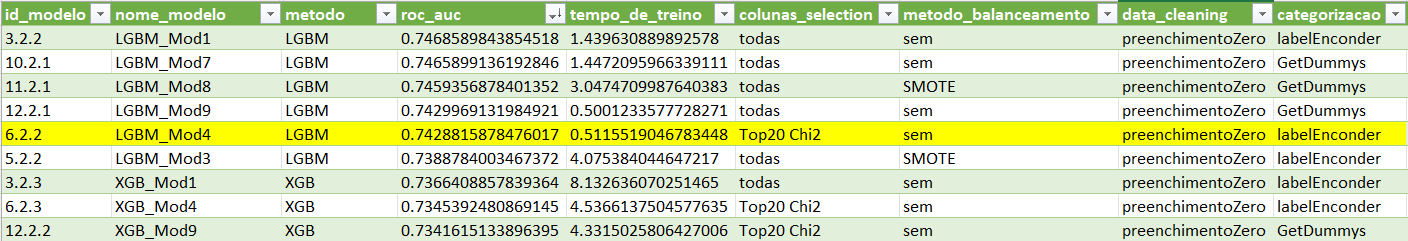

## Carga dos dados

In [175]:
infile = open('LGBM_Mod4.pkl','rb')
modelo = pickle.load(infile)
infile.close()

In [176]:
modelo.booster_

In [177]:
modelo.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [178]:
df_teste = pd.read_csv('test_databricks.csv')
df_teste = df_teste.rename(columns = lambda x:re.sub('[^A-Za-z0-9]+', '', x))

## Tratamento dos dados de teste

In [179]:
df_teste.shape

(61503, 121)

In [180]:
df_teste

,SKIDCURR,CNTCHILDREN,DAYSBIRTH,DAYSEMPLOYED,DAYSREGISTRATION,DAYSIDPUBLISH,OWNCARAGE,FLAGMOBIL,FLAGEMPPHONE,FLAGWORKPHONE,...,ELEVATORSMEDI,ENTRANCESMEDI,FLOORSMAXMEDI,FLOORSMINMEDI,LANDAREAMEDI,LIVINGAPARTMENTSMEDI,LIVINGAREAMEDI,NONLIVINGAPARTMENTSMEDI,NONLIVINGAREAMEDI,TOTALAREAMODE
0,202448,0,21105,3747,4990,4647,11.0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,393664,2,12966,5418,6621,4556,NaN,1,1,0,...,NaN,0.0690,0.0417,0.0833,0.0110,NaN,0.0132,NaN,0.0000,0.0102
2,315374,1,11838,690,742,2405,NaN,1,1,0,...,0.0,0.1379,0.1667,0.0417,0.0385,0.0684,0.0632,0.0000,0.0000,0.0659
3,412331,1,18234,1421,3585,1786,6.0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,218860,0,21883,-365243,12216,4552,NaN,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61498,102817,0,17817,3503,2886,1371,9.0,1,1,1,...,0.0,0.3103,0.0833,0.0417,0.1220,0.0693,0.0730,0.0078,0.0068,0.0652
61499,343961,0,22836,-365243,395,4591,NaN,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61500,427828,0,20014,-365243,10257,3524,18.0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61501,405956,0,8201,1381,1232,720,NaN,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [181]:
df_teste_chi2 = df_teste[cols_chi2]
df_teste_chi2

,NAMEINCOMETYPE,NAMEEDUCATIONTYPE,ORGANIZATIONTYPE,HOUSETYPEMODE,EMERGENCYSTATEMODE,DAYSBIRTH,DAYSEMPLOYED,DAYSREGISTRATION,DAYSIDPUBLISH,REGCITYNOTLIVECITY,REGCITYNOTWORKCITY,DEF30CNTSOCIALCIRCLE,DAYSLASTPHONECHANGE,AMTINCOMETOTAL,AMTCREDIT,AMTANNUITY,AMTGOODSPRICE,EXTSOURCE1,EXTSOURCE2,EXTSOURCE3
0,Working,Higher education,University,NaN,NaN,21105,3747,4990,4647,1,0,0.0,1582,450000.0,900000.0,45000.0,900000.0,NaN,0.741920,NaN
1,Commercial associate,Secondary / secondary special,Business Entity Type 3,block of flats,No,12966,5418,6621,4556,0,0,0.0,0,67500.0,202500.0,10125.0,202500.0,0.276370,0.646284,0.584990
2,Working,Secondary / secondary special,Self-employed,block of flats,No,11838,690,742,2405,0,0,0.0,134,112500.0,576837.0,16659.0,481500.0,0.183733,0.669266,0.742182
3,Working,Secondary / secondary special,Self-employed,NaN,NaN,18234,1421,3585,1786,0,1,0.0,372,135000.0,95940.0,10309.5,90000.0,NaN,0.616058,0.627991
4,Pensioner,Secondary / secondary special,XNA,NaN,NaN,21883,-365243,12216,4552,0,0,0.0,418,112500.0,678456.0,22014.0,486000.0,NaN,0.200775,0.761026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61498,Working,Secondary / secondary special,Self-employed,block of flats,No,17817,3503,2886,1371,1,1,0.0,1783,225000.0,472500.0,46161.0,454500.0,NaN,0.641852,NaN
61499,Pensioner,Secondary / secondary special,XNA,NaN,NaN,22836,-365243,395,4591,0,0,0.0,1095,112500.0,508495.5,24592.5,454500.0,NaN,0.297216,0.492060
61500,Pensioner,Secondary / secondary special,XNA,NaN,NaN,20014,-365243,10257,3524,0,0,0.0,799,157500.0,808650.0,23643.0,675000.0,NaN,0.596971,0.654529
61501,Commercial associate,Secondary / secondary special,Self-employed,NaN,NaN,8201,1381,1232,720,0,0,0.0,205,202500.0,590337.0,30271.5,477000.0,NaN,0.296855,0.701696


In [182]:
df_label_teste = df_teste_chi2[df_teste_chi2.select_dtypes('object').columns].apply(LabelEncoder().fit_transform)
df_label_teste = pd.concat([df_label_teste, df_teste_chi2.select_dtypes(exclude='object')], axis=1)
df_label_teste = df_label_teste.fillna(0)

In [183]:
df_label_teste

,NAMEINCOMETYPE,NAMEEDUCATIONTYPE,ORGANIZATIONTYPE,HOUSETYPEMODE,EMERGENCYSTATEMODE,DAYSBIRTH,DAYSEMPLOYED,DAYSREGISTRATION,DAYSIDPUBLISH,REGCITYNOTLIVECITY,REGCITYNOTWORKCITY,DEF30CNTSOCIALCIRCLE,DAYSLASTPHONECHANGE,AMTINCOMETOTAL,AMTCREDIT,AMTANNUITY,AMTGOODSPRICE,EXTSOURCE1,EXTSOURCE2,EXTSOURCE3
0,6,1,56,3,2,21105,3747,4990,4647,1,0,0.0,1582,450000.0,900000.0,45000.0,900000.0,0.000000,0.741920,0.000000
1,0,4,5,0,0,12966,5418,6621,4556,0,0,0.0,0,67500.0,202500.0,10125.0,202500.0,0.276370,0.646284,0.584990
2,6,4,42,0,0,11838,690,742,2405,0,0,0.0,134,112500.0,576837.0,16659.0,481500.0,0.183733,0.669266,0.742182
3,6,4,42,3,2,18234,1421,3585,1786,0,1,0.0,372,135000.0,95940.0,10309.5,90000.0,0.000000,0.616058,0.627991
4,2,4,57,3,2,21883,-365243,12216,4552,0,0,0.0,418,112500.0,678456.0,22014.0,486000.0,0.000000,0.200775,0.761026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61498,6,4,42,0,0,17817,3503,2886,1371,1,1,0.0,1783,225000.0,472500.0,46161.0,454500.0,0.000000,0.641852,0.000000
61499,2,4,57,3,2,22836,-365243,395,4591,0,0,0.0,1095,112500.0,508495.5,24592.5,454500.0,0.000000,0.297216,0.492060
61500,2,4,57,3,2,20014,-365243,10257,3524,0,0,0.0,799,157500.0,808650.0,23643.0,675000.0,0.000000,0.596971,0.654529
61501,0,4,42,3,2,8201,1381,1232,720,0,0,0.0,205,202500.0,590337.0,30271.5,477000.0,0.000000,0.296855,0.701696


## Execução da Classificação

In [184]:
y_predict_test = modelo.predict(df_label_teste)
y_proba_test = modelo.predict_proba(df_label_teste)

In [187]:
pd.DataFrame(y_predict_test).value_counts()

0    61378
1      125
dtype: int64

In [188]:

df_resultado = pd.concat([df_teste[['SKIDCURR']], pd.DataFrame(y_predict_test, columns=['Predict']), pd.DataFrame(y_proba_test[:,1], columns=['Proba'])], axis=1)
df_resultado

,SKIDCURR,Predict,Proba
0,202448,0,0.021962
1,393664,0,0.022465
2,315374,0,0.030962
3,412331,0,0.047391
4,218860,0,0.055672
...,...,...,...
61498,102817,0,0.045978
61499,343961,0,0.053408
61500,427828,0,0.035071
61501,405956,0,0.081886


In [189]:
df_resultado['Predict'].value_counts()

0    61378
1      125
Name: Predict, dtype: int64

In [190]:
df_resultado.to_csv('resultado_classificacao_teste.csv')
